In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# Spread rate choice

The goal of the notebook is to explore different ways to compute a spread rate of the COVID-19 for a given country using the cumulative time series of confirmed cases.

This spread rate will then be used to compare the evolution of the COVID-19 in different countries with the position, climate and urbanization of the countries.

## Plotting confirmed cases

Before choosing between different spread rate computation methods, let's plot the cumulative time series of confirmed cases for a few countries to visualize the tendency and the shape of the curves.

In [2]:
data = pd.read_csv('data/data.csv')
data = data.drop(columns=['Latitude', 'Longitude', 'Urban Population', 'Total Population', 'Mortality Rate', 'Mean temperature', 'Climate'])

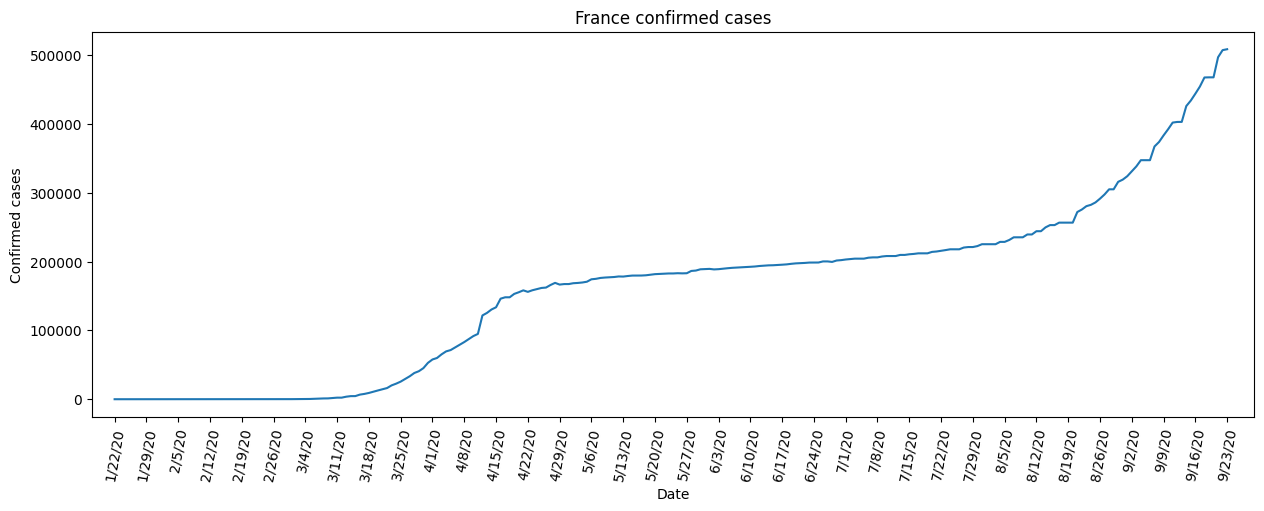

In [39]:
country = 'France'

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = country_data.columns
y = country_data.values[0]

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.title(f'{country} confirmed cases')
plt.xlim(-5, len(x) + 5)
plt.xlabel('Date')
plt.ylabel('Confirmed cases')
plt.xticks(rotation=80)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.show()

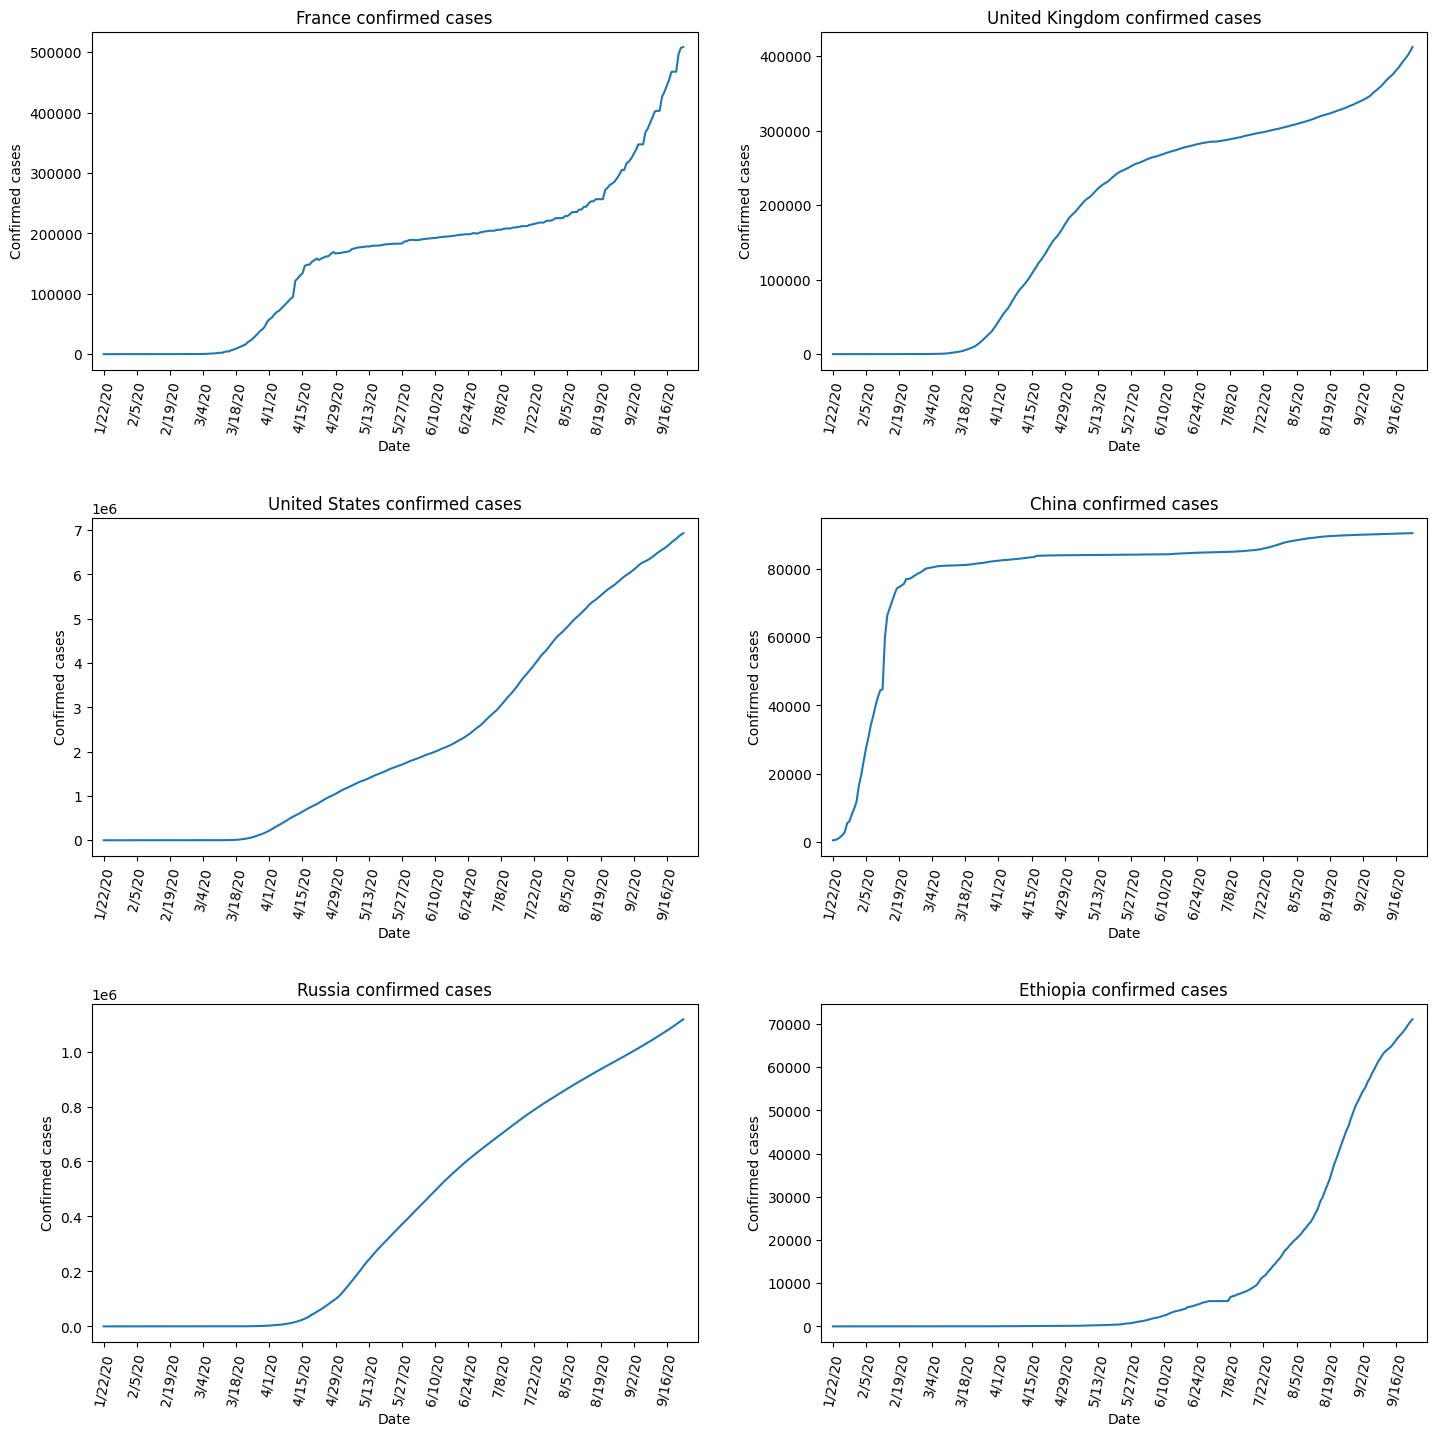

In [40]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))
for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = country_data.columns
    y = country_data.values[0]

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

We can see that the curves have very different shapes, some are linear, some are exponential, some have several phases. This is why it is important to choose a spread rate computation method that is robust to these different shapes.

## Exploring spread rate computation methods

We'll explore the following spread rate computation methods:
- Linear regression
- Exponential regression
- Time to double cases
- Daily reproduction number

### Linear regression
In this part, we'll fit a curve of the form $y = ax + b$ to the cumulative time series of confirmed cases. The slope of the linear regression will be the spread rate.

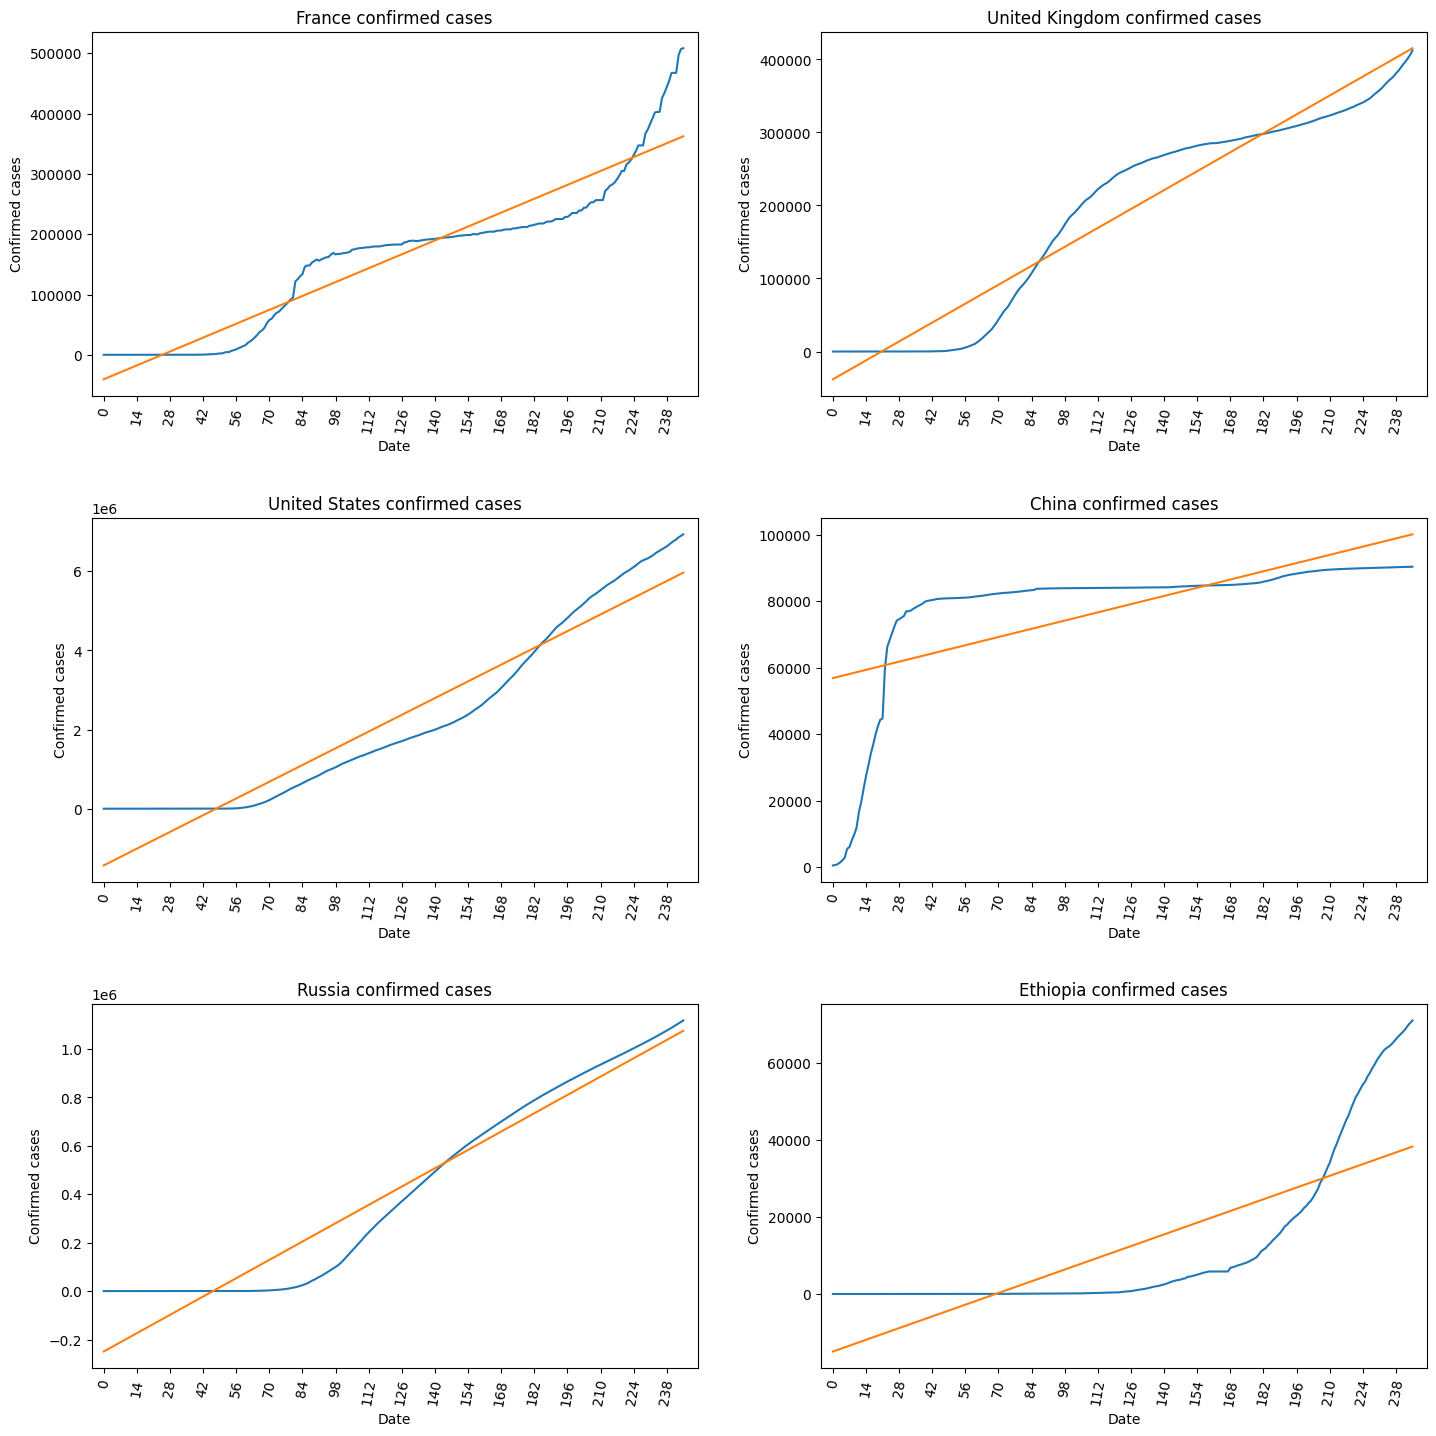

In [41]:
from sklearn.linear_model import LinearRegression


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    model = LinearRegression()
    model.fit([[i] for i in x], y)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, model.predict([[i] for i in x]))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we could have expected, the linear regression fits well for countries like Russia and USA that have a linear growth of confirmed cases. However, it is a terrible fit for Ethiopia whose curve looks more like an exponential.

### Exponential regression
In this part, we'll fit a curve of the form $y = \exp(ax + b)$ to the cumulative time series of confirmed cases. The slope of the exponential regression will be the spread rate.

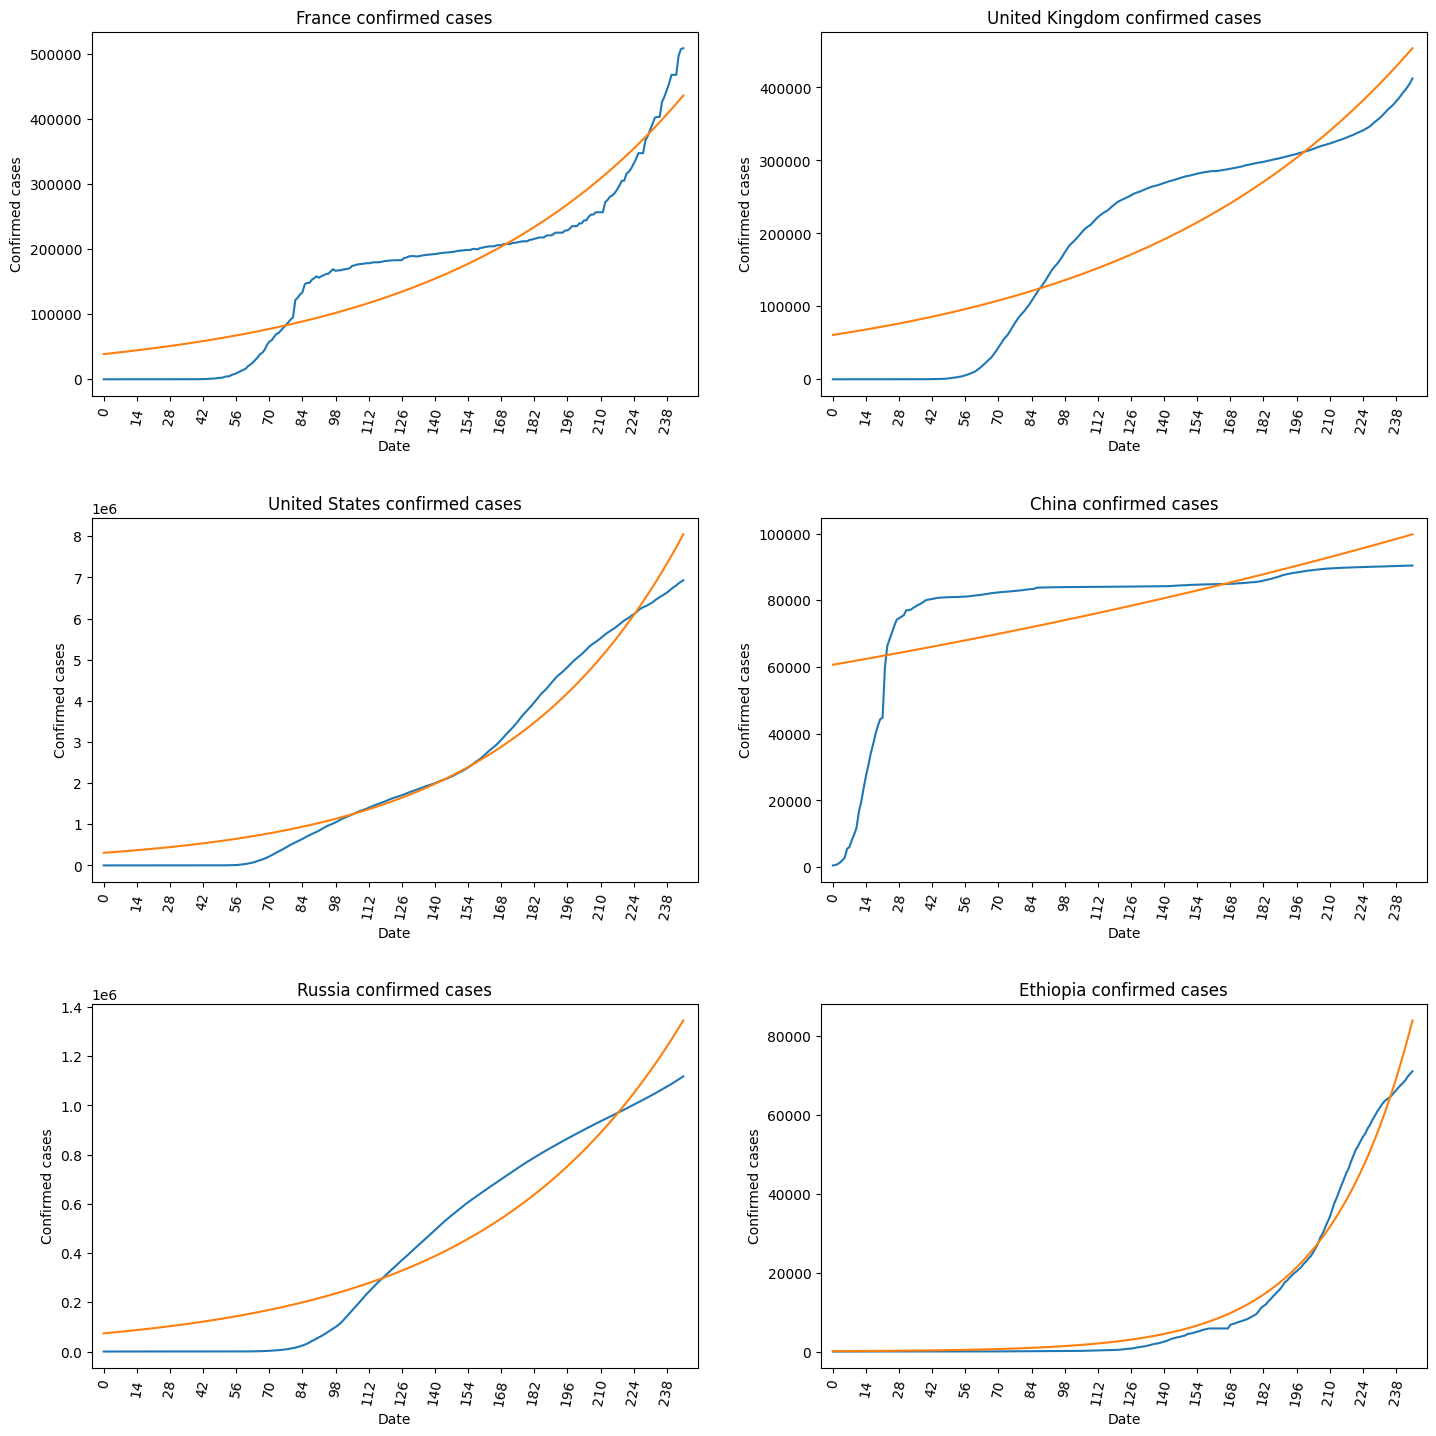

In [10]:
from scipy.optimize import curve_fit


countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia']

n = len(countries)
fig, axs = plt.subplots(math.ceil(n/2), 2, figsize=(15, 5 * math.ceil(n/2)))

def exponential(x, a, b):
    return np.exp(a * x + b)

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])

    x = range(len(country_data.columns))
    y = country_data.values[0]

    popt, _ = curve_fit(exponential, x, y, maxfev=1000000)

    axs[i//2, i%2].plot(x, y)
    axs[i//2, i%2].plot(x, exponential(x, *popt))
    axs[i//2, i%2].set_title(f'{country} confirmed cases')
    axs[i//2, i%2].set_xlim(-5, len(x) + 5)
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Confirmed cases')
    axs[i//2, i%2].tick_params(axis='x', rotation=80)
    axs[i//2, i%2].xaxis.set_major_locator(plt.MultipleLocator(14))
fig.tight_layout(pad=3.0)
plt.show()

As we can see, the exponential regression fits very well for Ethiopia and manages to do at least a decent fit for Russia and USA.

#### Clipping the time series
From the previous plots, we can see that the cumulative time series of confirmed cases is not always well suited for linear or exponential regression : some countries have curves that alternate between growth and stagnation phases.

The reason for this is probably that a lot of countries have implemented measures to slow down the spread of the COVID-19 and this means that the natural spread rate that we are trying to capture is not visible in every part of the time series.

To solve this problem, we can clip the time series to only keep the part where the derivative of the time series is the highest using the method chosen in the corresponding notebook. 

To take into account the fact that the highest derivative is not always berfore the first plateau (like in France's case), we can also subtract the first value of the clipped time series to the whole clipped time series to make fitting easier.

In [5]:
def moving_average(data, window):
    s = pd.Series(data).rolling(window=window, min_periods=1).mean()
    s.fillna(data[:window].mean(), inplace=True)
    return s

def clip_spot_derivative(country_data, start_threshold=0.05, end_threshold=0.7):
    country_data = np.array(country_data).reshape(-1, 1)
    d1 = np.diff(country_data, axis=0)
    max_ = np.argmax(d1)
    start = 0
    end = len(country_data)
    for i in range(max_, 0, -1):
        if d1[i] < start_threshold * max(d1):
            start = i
            break
    for i in range(max_, len(d1)):
        if d1[i] < end_threshold * max(d1):
            end = i
            break
    return start, end

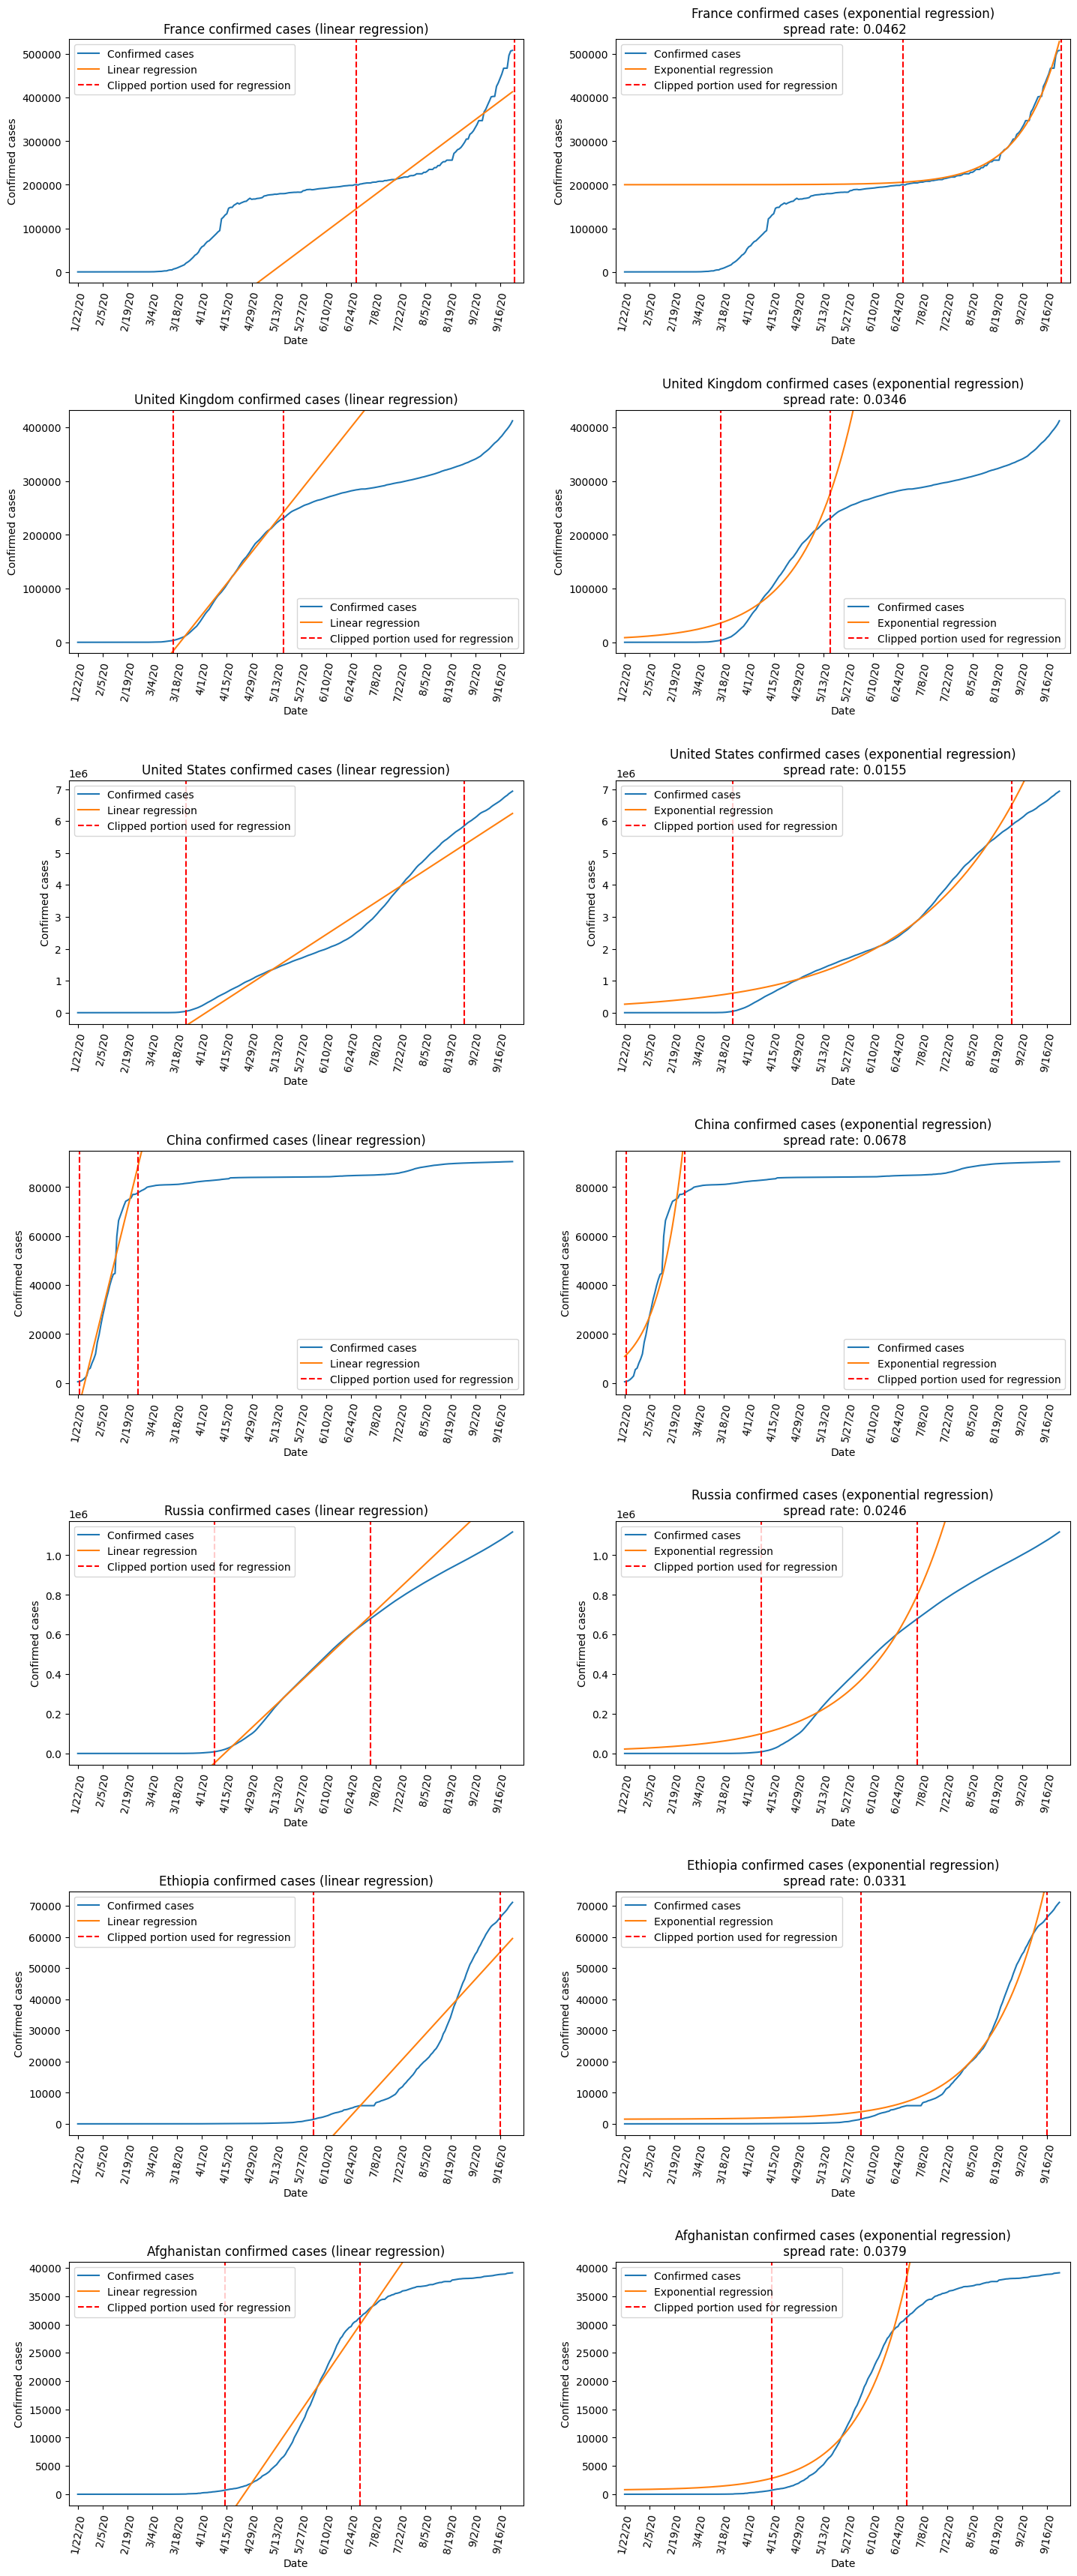

In [44]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia', 'Afghanistan']
n = len(countries)
fig, axs = plt.subplots(n, 2, figsize=(15, 5 * n))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    model = LinearRegression()
    model.fit([[i] for i in x[start:end]], translated_clipped)

    popt, _ = curve_fit(exponential, x[start:end], translated_clipped, maxfev=1000000)

    axs[i, 0].plot(country_data.columns, y)
    axs[i, 0].plot(country_data.columns, model.predict([[i] for i in x]) + y[start])
    axs[i, 0].set_title(f'{country} confirmed cases (linear regression)')
    axs[i, 0].set_xlim(-5, len(x) + 5)
    axs[i, 0].set_ylim(-0.05 * max(y), 1.05 * max(y))
    axs[i, 0].set_xlabel('Date')
    axs[i, 0].set_ylabel('Confirmed cases')
    axs[i, 0].tick_params(axis='x', rotation=80)
    axs[i, 0].xaxis.set_major_locator(plt.MultipleLocator(14))

    axs[i, 1].plot(country_data.columns, y)
    axs[i, 1].plot(country_data.columns, exponential(x, *popt) + y[start])
    axs[i, 1].set_title(f'{country} confirmed cases (exponential regression)\n spread rate: {popt[0]:.4f}')
    axs[i, 1].set_xlim(-5, len(x) + 5)
    axs[i, 1].set_ylim(-0.05 * max(y), 1.05 * max(y))
    axs[i, 1].set_xlabel('Date')
    axs[i, 1].set_ylabel('Confirmed cases')
    axs[i, 1].tick_params(axis='x', rotation=80)
    axs[i, 1].xaxis.set_major_locator(plt.MultipleLocator(14))

    # Highlight the portion used for regression
    axs[i, 0].axvline(x=start, color='r', linestyle='--')
    axs[i, 0].axvline(x=end, color='r', linestyle='--')
    axs[i, 1].axvline(x=start, color='r', linestyle='--')
    axs[i, 1].axvline(x=end, color='r', linestyle='--')
    
    # Add legend
    axs[i, 0].legend(['Confirmed cases', 'Linear regression', 'Clipped portion used for regression'])
    axs[i, 1].legend(['Confirmed cases', 'Exponential regression', 'Clipped portion used for regression'])

fig.tight_layout(pad=3.0)
plt.show()

Exponential regression fits well for all countries when the time series is clipped and the confirmed cases are translated to start at 0 at the beginning of the clipped time series.

We could then use the slope of the exponential regression as the spread rate.

### Time to double cases
Another way to compute the spread rate is to compute the time it takes for the number of confirmed cases to double. This method is robust to the shape of the curve and is easy to compute but since we clipped the times series at some arbitrary point, the initialization won't be the same for each country even after translation. Some countries could have already gained a certain momentum at the beginning of the clipped time series and this would make the time to double cases smaller than it should be.

To prevent that, we could only take into account the time to double cases after a certain portion of the time series has passed in hope that the spread rate has stabilized. (e.g. only considering the last 75% of the clipped time series)

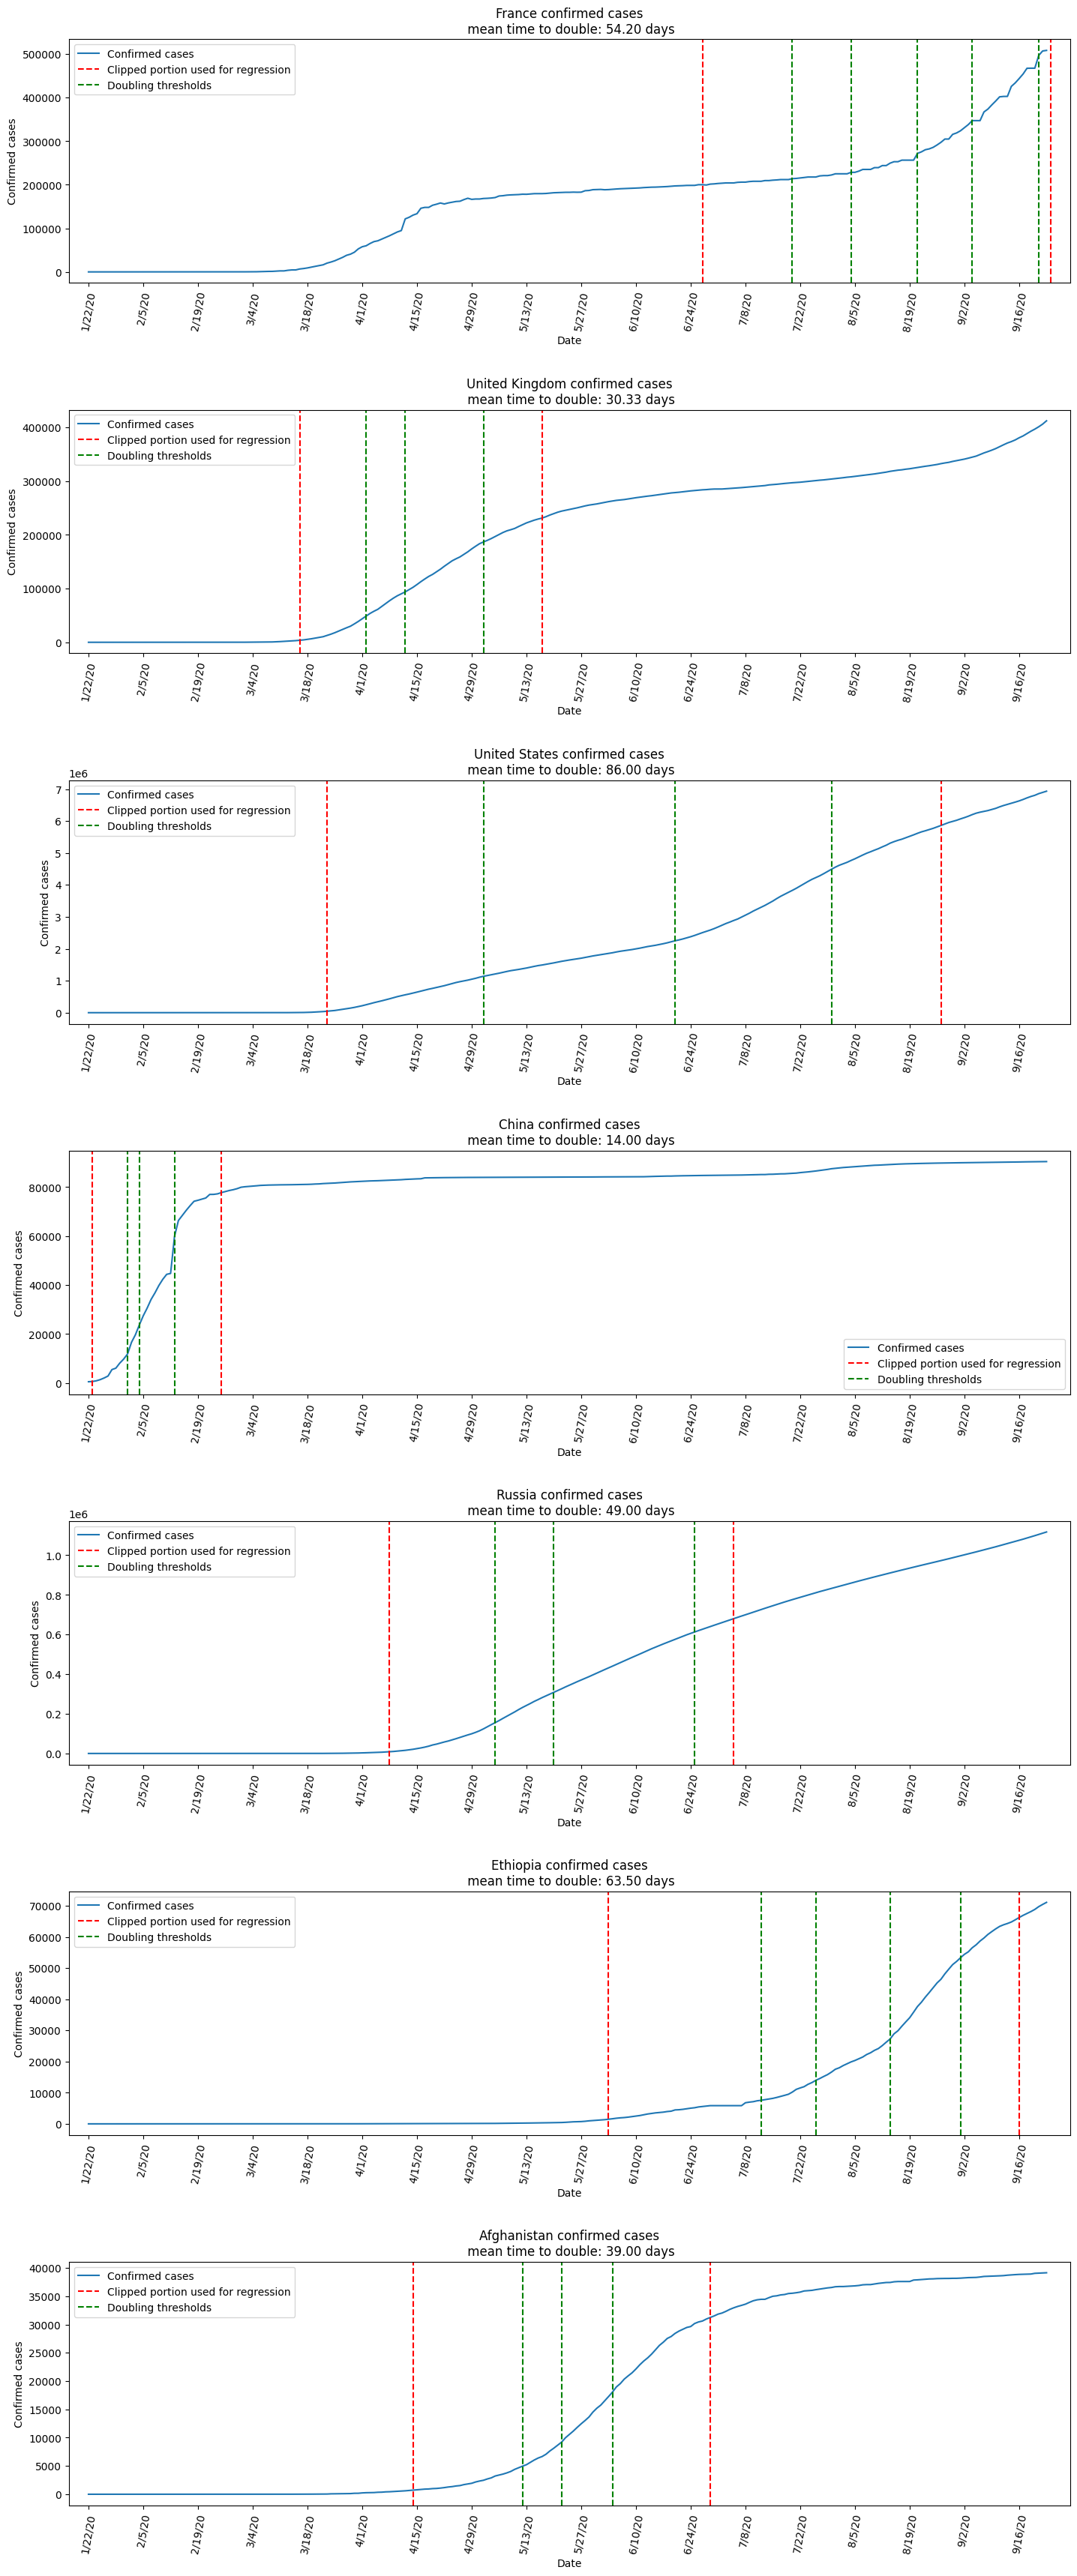

In [6]:
def time_to_double(translated_clipped, initial_threshold=0.1):
    nb_days = []
    current_confirmed = translated_clipped[0]
    for i in range(1, len(translated_clipped)):
        if translated_clipped[i] > 2 * current_confirmed:
            nb_days.append(i)
            current_confirmed = translated_clipped[i]
    return [n for n in nb_days if n > initial_threshold * len(translated_clipped)]

countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia', 'Afghanistan']

n = len(countries)
fig, axs = plt.subplots(n, 1, figsize=(15, 5 * n))

for i, country in enumerate(countries):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    nb_days_to_double = time_to_double(translated_clipped, initial_threshold=0.25)
    mean_time_to_double = sum(nb_days_to_double) / len(nb_days_to_double)

    axs[i].plot(country_data.columns, y)
    axs[i].set_title(f'{country} confirmed cases\n mean time to double: {mean_time_to_double:.2f} days')
    axs[i].set_xlim(-5, len(x) + 5)
    axs[i].set_ylim(-0.05 * max(y), 1.05 * max(y))
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Confirmed cases')
    axs[i].tick_params(axis='x', rotation=80)
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(14))

    # Highlight the portion used for regression
    axs[i].axvline(x=start, color='r', linestyle='--')

    # Add doubling thresholds horizontal lines
    for day in nb_days_to_double:
        # axs[i].axhline(y=y[start + day], color='g', linestyle='--')
        axs[i].axvline(x=country_data.columns[start + day], color='g', linestyle='--')

    # Highlight the portion used for regression
    axs[i].axvline(x=end, color='r', linestyle='--')


    # Add legend
    axs[i].legend(['Confirmed cases', 'Clipped portion used for regression', 'Doubling thresholds'])

fig.tight_layout(pad=3.0)
plt.show()

### Daily reproduction number
Starting with our clipped time series $c$, we can define a daily reproduction number like this : $\frac{c_{i+1}-c_i}{c_i}$

It corresponds to the daily relative increase in confirmed cases.

In [7]:
def daily_reproduction_numbers(translated_clipped, initial_threshold=0.1):
    d = []
    n = len(translated_clipped)
    start = math.ceil(initial_threshold * n)
    for i in range(start, n):
        d.append((translated_clipped[i] - translated_clipped[i-1])/translated_clipped[i-1])
    return d

countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia', 'Afghanistan']
n = len(countries)

print('Mean daily reproduction numbers:')
for country in countries:
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    d = daily_reproduction_numbers(translated_clipped, initial_threshold=0.25)

    print(f'{country:>18}: {sum(d)/len(d):.3f}')

Mean daily reproduction numbers:
            France: 0.052
    United Kingdom: 0.042
     United States: 0.015
             China: 0.098
            Russia: 0.031
          Ethiopia: 0.035
       Afghanistan: 0.052


## Comparing our spread rate computation methods
Now we have 4 different spread rate computation methods, we can compare them to see if they are consistent with each other and if they are consistent with the evolution of the COVID-19 in different countries.

We'll actually rule out the linear regression method because the spread rate extracted being the slope of the linear regression, it is really sensitive to the total number of confirmed cases in the country and thus to the size of the country. This is not a good property for a spread rate computation method.

In [47]:
countries = ['France', 'United Kingdom', 'United States', 'China', 'Russia', 'Ethiopia', 'Afghanistan']
n = len(countries)

exp_slope = []
mean_time_to_double = []
mean_daily_reproduction_numbers = []

for country in countries:
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    popt, _ = curve_fit(exponential, x[start:end], translated_clipped, maxfev=1000000)
    exp_slope.append(popt[0])

    nb_days_to_double = time_to_double(translated_clipped, initial_threshold=0.25)
    mean_time_to_double.append(sum(nb_days_to_double) / len(nb_days_to_double))

    d = daily_reproduction_numbers(translated_clipped, initial_threshold=0.25)
    mean_daily_reproduction_numbers.append(sum(d)/len(d))

print(' '*25 + 'exponential slope\tmean time to double\tmean daily reproduction numbers')
for country, exp, time, reproduction in zip(countries, exp_slope, mean_time_to_double, mean_daily_reproduction_numbers):
    print(f'{country:>18}:      {exp:>17.4f}\t{time:>19.2f}\t{reproduction:>31.3f}')

                         exponential slope	mean time to double	mean daily reproduction numbers
            France:                 0.0462	              54.20	                          0.052
    United Kingdom:                 0.0346	              30.33	                          0.042
     United States:                 0.0155	              86.00	                          0.015
             China:                 0.0678	              14.00	                          0.098
            Russia:                 0.0246	              49.00	                          0.031
          Ethiopia:                 0.0331	              63.50	                          0.035
       Afghanistan:                 0.0379	              39.00	                          0.052


We seem to have a good consistency between the different methods. We can now scale them between 0 and 1 using the min-max scaling method to get a better comparison.

In [48]:
exp_slope_scaled = [(e - min(exp_slope)) / (max(exp_slope) - min(exp_slope)) for e in exp_slope]

mean_time_to_double_scaled = [max(mean_time_to_double) - t for t in mean_time_to_double]
mean_time_to_double_scaled = [t / max(mean_time_to_double_scaled) for t in mean_time_to_double_scaled]

mean_daily_reproduction_numbers_scaled = [(r - min(mean_daily_reproduction_numbers)) / (max(mean_daily_reproduction_numbers) - min(mean_daily_reproduction_numbers)) for r in mean_daily_reproduction_numbers]

print('Scaled rates:')
print(' '*25 + 'exponential slope\tmean time to double\tmean daily reproduction numbers')
for country, exp, time, reproduction in zip(countries, exp_slope_scaled, mean_time_to_double_scaled, mean_daily_reproduction_numbers_scaled):
    print(f'{country:>18}:      {exp:>17.2f}\t{time:>19.2f}\t{reproduction:>31.2f}')

Scaled rates:
                         exponential slope	mean time to double	mean daily reproduction numbers
            France:                   0.59	               0.44	                           0.45
    United Kingdom:                   0.37	               0.77	                           0.33
     United States:                   0.00	               0.00	                           0.00
             China:                   1.00	               1.00	                           1.00
            Russia:                   0.17	               0.51	                           0.20
          Ethiopia:                   0.34	               0.31	                           0.25
       Afghanistan:                   0.43	               0.65	                           0.45


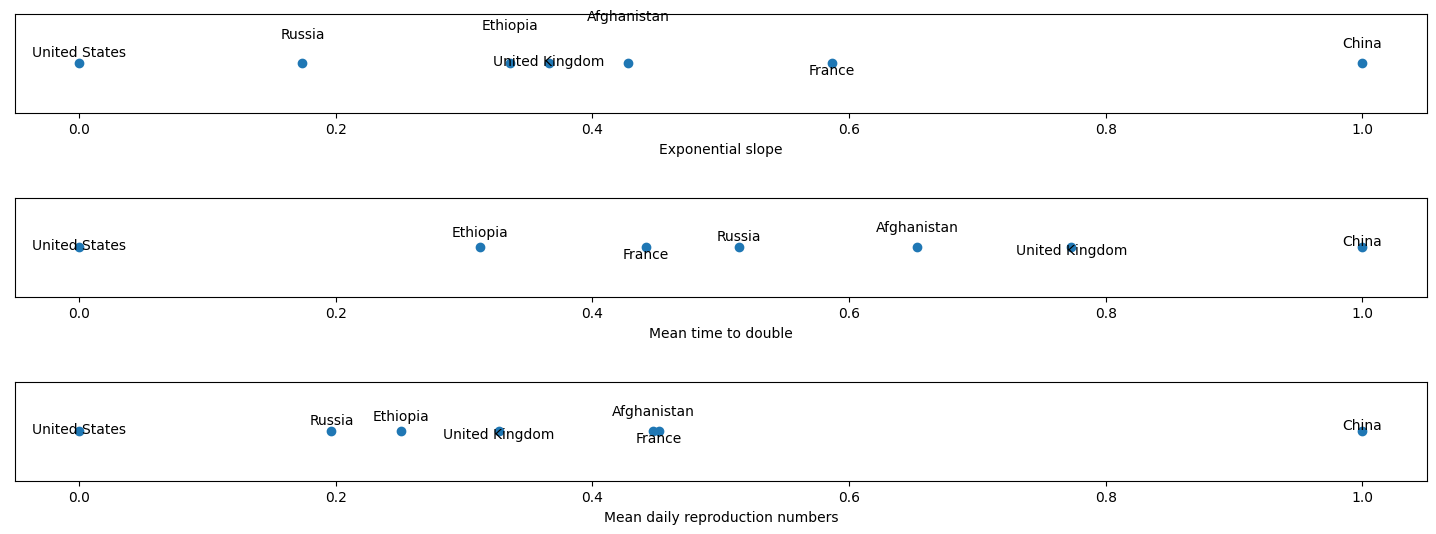

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(15, 6))

ax[0].scatter(exp_slope_scaled, [0]*len(countries))
ax[0].set_yticks([])
ax[0].set_xlabel('Exponential slope')
for i, country in enumerate(countries):
    ax[0].text(exp_slope_scaled[i], i*0.01, country, ha='center', va='top')

ax[1].scatter(mean_time_to_double_scaled, [0]*len(countries))
ax[1].set_yticks([])
ax[1].set_xlabel('Mean time to double')
for i, country in enumerate(countries):
    ax[1].text(mean_time_to_double_scaled[i], i*0.005, country, ha='center', va='top')

ax[2].scatter(mean_daily_reproduction_numbers_scaled, [0]*len(countries))
ax[2].set_yticks([])
ax[2].set_xlabel('Mean daily reproduction numbers')
for i, country in enumerate(countries):
    ax[2].text(mean_daily_reproduction_numbers_scaled[i], i*0.005, country, ha='center', va='top')

plt.tight_layout(pad=3.0)
plt.show()

Exponential regression and mean daily reproduction number seem to give similar results.

In [8]:
def exp_spread_rate(country, data):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    popt, _ = curve_fit(exponential, x[start:end], translated_clipped, maxfev=10000000)
    return popt[0]

def time_to_double_rate(country, data):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    nb_days_to_double = time_to_double(translated_clipped, initial_threshold=0.25)
    return sum(nb_days_to_double) / len(nb_days_to_double) if len(nb_days_to_double) > 0 else len(data.columns)

def daily_reproduction_rate(country, data):
    country_data = data[data['Country'] == country]
    country_data = country_data.drop(columns=['Country'])
    country_data_smooth = moving_average(country_data.values[0], 20)

    x = range(len(country_data.columns))
    y = country_data.values[0]

    start, end = clip_spot_derivative(country_data_smooth, end_threshold=0.7)

    translated_clipped = y[start:end] - y[start]

    d = daily_reproduction_numbers(translated_clipped, initial_threshold=0.25)
    return sum(d)/len(d)

In [12]:
# Exponential spread rate

countries = data['Country'].values
exp_rates = [exp_spread_rate(country, data) for country in countries]

exp_rates_scaled = [(e - min(exp_rates)) / (max(exp_rates) - min(exp_rates)) for e in exp_rates]

print(exp_rates_scaled[152]) # United States
print(exp_rates_scaled[120]) # Russia
print(exp_rates_scaled[49]) # Ethiopia
print(exp_rates_scaled[151]) # United Kingdom
print(exp_rates_scaled[0]) # Afghanistan
print(exp_rates_scaled[52]) # France
print(exp_rates_scaled[33]) # China

C:\Users\LV\AppData\Local\Temp\ipykernel_24412\3404411974.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exponential, x[start:end], translated_clipped, maxfev=10000000)


0.0619167402791806
0.13070669677075444
0.19473996175801817
0.20659033237621469
0.23101711767690666
0.29367882773394166
0.45710674765239256


In [13]:
# Time to double

countries = data['Country'].values
time_to_doubles = [time_to_double_rate(country, data) for country in countries]

time_to_doubles_scaled = [max(time_to_doubles) - t for t in time_to_doubles]
time_to_doubles_scaled = [t / max(time_to_doubles_scaled) for t in time_to_doubles_scaled]

print(time_to_doubles_scaled[152]) # United States
print(time_to_doubles_scaled[120]) # Russia
print(time_to_doubles_scaled[49]) # Ethiopia
print(time_to_doubles_scaled[151]) # United Kingdom
print(time_to_doubles_scaled[0]) # Afghanistan
print(time_to_doubles_scaled[52]) # France
print(time_to_doubles_scaled[33]) # China

0.6708333333333333
0.825
0.7645833333333333
0.9027777777777778
0.8666666666666667
0.8033333333333333
0.9708333333333333


In [14]:
# Daily reproduction rate

countries = data['Country'].values
reproduction_rates = [daily_reproduction_rate(country, data) for country in countries]

reproduction_rates_scaled = [(r - min(reproduction_rates)) / (max(reproduction_rates) - min(reproduction_rates)) for r in reproduction_rates]

print(reproduction_rates_scaled[152]) # United States
print(reproduction_rates_scaled[120]) # Russia
print(reproduction_rates_scaled[49]) # Ethiopia
print(reproduction_rates_scaled[151]) # United Kingdom
print(reproduction_rates_scaled[0]) # Afghanistan
print(reproduction_rates_scaled[52]) # France
print(reproduction_rates_scaled[33]) # China

0.08546548748950894
0.18128540105927482
0.20785663246375258
0.24482491300069423
0.3033573094998078
0.3056586969896995
0.5727949321271598


#### Correlations between the different methods

In [15]:
corr = np.corrcoef([exp_rates_scaled, time_to_doubles_scaled, reproduction_rates_scaled])
print(corr)

[[1.         0.43493893 0.78100956]
 [0.43493893 1.         0.61207289]
 [0.78100956 0.61207289 1.        ]]


As we saw earlier, the exponential regression and the mean daily reproduction number give close results where the time to double cases is a bit different.

## Exporting the spread rates

In [27]:
data = pd.read_csv('data/data.csv')
data.drop(columns=data.columns.to_list()[8:], inplace=True)
data['Spread rate'] = exp_rates_scaled
# data.to_csv('data/data_spread_rate_exp.csv', index=False)

In [23]:
data = pd.read_csv('data/data.csv')
data.drop(columns=data.columns.to_list()[8:], inplace=True)
data['Spread rate'] = time_to_doubles_scaled
# data.to_csv('data/data_spread_rate_time.csv', index=False)

In [16]:
data = pd.read_csv('data/data.csv')
data.drop(columns=data.columns.to_list()[8:], inplace=True)
data['Spread rate'] = reproduction_rates_scaled
# data.to_csv('data/data_spread_rate_reproduction.csv', index=False)